# Basketball Fantasy League Recommender System

This Jupyter notebook is part of a comprehensive educational project that demonstrates the integration of data engineering and machine learning concepts. The project showcases three key components: API development, ETL (Extract, Transform, Load) processes, and recommender systems. Specifically, we leverage a custom-built BasketballAPI that generates fictional basketball player data and statistics across multiple seasons by simulating the `nba_api` which is an API Client for www.nba.com. This data is then processed through a Python-based ETL pipeline that cleanly transforms and stores the information in a CSV format. Ultimately, we use different type of recommender systems to solve a fictional fantasy league problem.

The project follows the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology, which provides a structured approach through six key phases:
1. **Business Understanding**: Defining the need for a fantasy basketball recommender system
2. **Data Understanding**: Analyzing the BasketballAPI data structure and statistical patterns
3. **Data Preparation**: ETL processes to clean and transform the raw API data
4. **Modeling**: Implementing various recommender system algorithms
5. **Evaluation**: Testing the recommendations' accuracy and relevance
6. **Deployment**: Creating a usable system for fantasy basketball managers

While the project encompasses multiple technical aspects, this notebook primarily focuses on building and evaluating different recommender system techniques to suggest similar players based on their statistical performance and characteristics. This practical approach allows us to explore real-world applications of data science while working with a controlled, yet realistic dataset that simulates five seasons of basketball data across 390 players and multiple teams.

### Import Modules - Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from BasicRec import FantasyReccomenderBasic
from FantasyAdvanced import FantasyRecommenderAdvanced
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 800)
%matplotlib inline

In [2]:
df = pd.read_csv('basketball_data.csv')

### Exploratory Data Analysis (EDA)

In [3]:
df.head()

,player_id,player_name,archetype,season,team,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
0,0,Robert Smith,regular,2019-20,SkyBirds,55,36.3,5.4,3.9,NaN,1.2,0.2,0.400,0.302,0.709
1,1,Mandy Evans,regular,2019-20,SparkiFY,38,14.8,17.9,5.9,3.9,1.6,0.5,0.431,0.369,0.734
2,2,Miguel Lee,regular,2019-20,SkyBirds,79,17.2,10.1,7.2,2.5,1.4,1.2,0.432,0.322,0.792
3,3,Ashlee Martin,regular,2019-20,HtmlERS,46,31.6,11.6,7.0,3.5,0.5,1.1,0.474,0.365,0.739
4,4,David Hamilton,regular,2019-20,SparkiFY,37,31.9,8.9,6.4,NaN,1.7,0.8,0.433,0.329,NaN


In [4]:
print(f" The dataframe has {df.shape[0]} records and {df.shape[1]} attributes.")

 The dataframe has 1950 records and 15 attributes.


In [5]:
df.dtypes

player_id         int64
player_name      object
archetype        object
season           object
team             object
games_played      int64
minutes         float64
points          float64
rebounds        float64
assists         float64
steals          float64
blocks          float64
fg_pct          float64
fg3_pct         float64
ft_pct          float64
dtype: object

<p><i>Does this dataframe present duplicate values? </i></p>

In [6]:
print(f"The dataframe should contain {df.player_id.nunique()} unique player")

The dataframe should contain 390 unique player


In [7]:
df.groupby('season')['player_id'].count()

season
2019-20    390
2020-21    390
2021-22    390
2022-23    390
2023-24    390
Name: player_id, dtype: int64

<p> <i> Is the relation player-team unique, or do players change team during the course of five seasons? if they do change, what is the ratio?</p>

In [8]:
players_swapped = df.groupby('player_id')['team']\
    .nunique()\
    .reset_index()\
    .rename(columns={'team': 'unique_teams'})
players_swapped_list = players_swapped[players_swapped['unique_teams']>1]\
                                                 ['player_id'].tolist()


In [9]:
print(
    f"Out of {df.player_id.nunique()} players during the 5 seasons analyzed, "
    f"{len(players_swapped_list)} players changed teams, which is a ratio of "
    f"{len(players_swapped_list) / df.player_id.nunique():.2f}."
)


Out of 390 players during the 5 seasons analyzed, 40 players changed teams, which is a ratio of 0.10.


<p> <i>Does the dataframe presents any null values?</i></p>


In [10]:
df.isnull().any()

player_id       False
player_name     False
archetype       False
season          False
team            False
games_played    False
minutes         False
points           True
rebounds         True
assists          True
steals           True
blocks           True
fg_pct           True
fg3_pct          True
ft_pct           True
dtype: bool

In [11]:
print(f" There are {df.isnull().any().sum()} attribues with missing values")

 There are 8 attribues with missing values


In [12]:
#(df.isnull().sum() / df.shape[0])
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
missing_percentage = missing_percentage[missing_percentage > 0]  
print(missing_percentage)


points      5.435897
rebounds    5.435897
assists     5.538462
steals      4.358974
blocks      4.205128
fg_pct      3.538462
fg3_pct     5.384615
ft_pct      5.230769
dtype: float64


In [13]:
print(f" On average these fields have {round(missing_percentage.mean(),1)} of missing values")

 On average these fields have 4.9 of missing values


<p>  <i>This is something to keep into account as we develop our models.Next we to observe the distributions of some attributes. Now let's look at some summary statics.</i></p>

In [14]:
df.iloc[:,1:].describe()

,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
count,1950.000000,1950.000000,1844.000000,1844.000000,1842.000000,1865.000000,1868.000000,1881.000000,1845.000000,1848.000000
mean,51.735385,25.105949,11.420174,4.495824,3.033659,1.009330,0.641328,0.446874,0.330622,0.752390
std,18.249953,7.595495,5.761876,1.934746,1.938258,0.537009,0.426800,0.048509,0.036472,0.067144
min,20.000000,12.100000,2.000000,1.000000,0.500000,0.000000,0.000000,0.350000,0.250000,0.601000
25%,36.000000,18.400000,7.400000,3.100000,1.700000,0.600000,0.400000,0.413000,0.306000,0.706000
50%,52.000000,25.150000,10.700000,4.200000,2.700000,0.900000,0.500000,0.443000,0.329000,0.748000
75%,68.000000,31.900000,14.400000,5.800000,3.800000,1.300000,0.800000,0.476000,0.354000,0.801000
max,82.000000,38.000000,34.800000,12.000000,11.900000,3.000000,3.000000,0.647000,0.449000,0.947000


<p> <i> The attribute games_played appears to have higher variation. It would be helpful to plot the related histogram.</i></p>

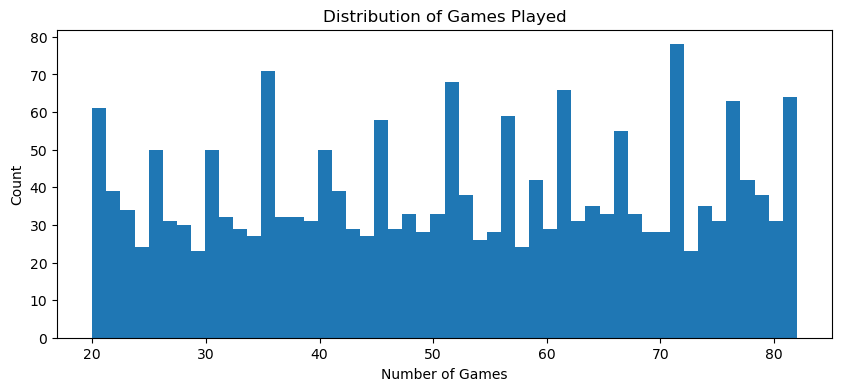

In [15]:
# Create histogram
plt.figure(figsize=(10, 4))
plt.hist(df['games_played'], bins=50)
plt.title('Distribution of Games Played')
plt.xlabel('Number of Games')
plt.ylabel('Count')
plt.show()

<p> <i> A box-plot could help identify any outliers. </i></p>

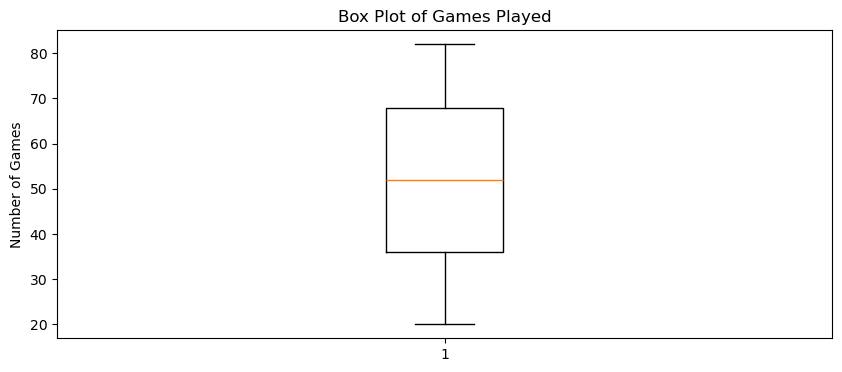

In [16]:
# Create box plot
plt.figure(figsize=(10, 4))
plt.boxplot(df.games_played)
plt.title('Box Plot of Games Played')
plt.ylabel('Number of Games')
plt.show();

<p><i> The box plot of the games_played attribute doesn't present any outliers. Considering the implaction of null values and the fact that there is only a 5% percentage we will proceed to eliminate such values from the dataset used for this project. </i></p>

In [17]:
df = df.dropna(subset=[
        'points', 'rebounds', 'assists', 'steals', 'blocks',
        'fg_pct', 'fg3_pct', 'ft_pct'
    ]).reset_index(drop=True)
df.head()

,player_id,player_name,archetype,season,team,games_played,minutes,points,rebounds,assists,steals,blocks,fg_pct,fg3_pct,ft_pct
0,1,Mandy Evans,regular,2019-20,SparkiFY,38,14.8,17.9,5.9,3.9,1.6,0.5,0.431,0.369,0.734
1,2,Miguel Lee,regular,2019-20,SkyBirds,79,17.2,10.1,7.2,2.5,1.4,1.2,0.432,0.322,0.792
2,3,Ashlee Martin,regular,2019-20,HtmlERS,46,31.6,11.6,7.0,3.5,0.5,1.1,0.474,0.365,0.739
3,5,Anna Thompson,regular,2019-20,HtmlERS,23,19.6,13.6,6.6,4.1,1.2,0.7,0.511,0.330,0.838
4,6,Angela Kelly,regular,2019-20,SkyBirds,41,18.9,10.9,4.9,1.0,0.9,0.3,0.442,0.336,0.781


### Rank-Based Recommendations

In this scenario, we are just getting started with a basketball fantasy league and we have no knowledge of players' interactions from previous fantasy leagues except for player and teams data acquired via API. Thus, a rank-based system (a rule-based recommender) would focus on sorting players according to specific performance metrics and consequent composite score. For the purpose of this project, we can prioritize metrics such as points, rebounds, assists, blocks, and steals, assuming a Head to Head league's scoring system.

In [18]:
# Adding a 'traded' feature: Check if a player changed teams

df['traded'] = df.groupby('player_id')['team'].transform('nunique') > 1


In [24]:
recommender = FantasyReccomenderBasic(df)
top_recommendations = recommender.create_rank_based_recommendations(top_n=10)
print('Top 10 Reccomended Players')
print(top_recommendations)

Top 10 Reccomended Players
   player_id     player_name              team  composite_score  traded  \
0        270  Richard Morris        VBADragons         0.631105   False   
1        147  Kristen Murphy          SparkiFY         0.616644   False   
2         39      James Mack         BIsupremE         0.611875   False   
3        330    Theresa Cook      UnitedWeCode         0.601391   False   
4        284      Diana Cain           LutammS         0.599319   False   
5        241     Todd Garcia        VBADragons         0.599099    True   
6        277   Robert Rivera  KeyBoardWarriors         0.579443   False   
7        383   Ashley Fisher         BIsupremE         0.569330   False   
8        321   Melissa Doyle           HtmlERS         0.565963   False   
9        365    Tracey Blair           HtmlERS         0.564878   False   

         archetype  
0     elite_scorer  
1     elite_scorer  
2     elite_scorer  
3     elite_scorer  
4  elite_playmaker  
5     elite_scorer  


In [25]:
coverage = len(top_recommendations) / len(df)
archetype_distribution = top_recommendations['archetype'].value_counts(normalize=True) * 100

elite_count = top_recommendations['archetype'].str.contains('elite').sum()
elite_bias = elite_count / len(top_recommendations) if len(top_recommendations) > 0 else 0
elite_player_count = df[df['archetype'].str.contains('elite')].shape[0]
elite_coverage = elite_count / elite_player_count if elite_player_count > 0 else 0

# Summary Metrics
print(f"Coverage: {coverage}")
print(f"Elite Bias: {elite_bias:.2f}")
print(f"Elite Coverage: {elite_coverage:.2f}")
print("\nArchetype Distribution in Recommendations:")
print(archetype_distribution)

Coverage: 0.007733952049497293
Elite Bias: 1.00
Elite Coverage: 0.05

Archetype Distribution in Recommendations:
archetype
elite_scorer       50.0
elite_playmaker    50.0
Name: proportion, dtype: float64


### Enanched Rank-Based Recommendations

<i>We can enhance the previous FantasyRecommender by ensuring that recommendations do not include unavailable players as specified by user's input.</i>

In [26]:
recommender = FantasyRecommenderAdvanced(df)

# Get recommendations excluding unavailable players
unavailable_players = [270,147,39]
top_recommendations = recommender.create_rank_based_recommendations(unavailable_players=unavailable_players, top_n=10)
print(top_recommendations)

    player_id       player_name              team  composite_score  traded  \
3         330      Theresa Cook      UnitedWeCode         0.601391   False   
4         284        Diana Cain           LutammS         0.599319   False   
5         241       Todd Garcia        VBADragons         0.599099    True   
6         277     Robert Rivera  KeyBoardWarriors         0.579443   False   
7         383     Ashley Fisher         BIsupremE         0.569330   False   
8         321     Melissa Doyle           HtmlERS         0.565963   False   
9         365      Tracey Blair           HtmlERS         0.564878   False   
10        183      Connor Lopez           HtmlERS         0.561267   False   
11        174  Nathaniel Vaughn         BIsupremE         0.559483   False   
12        193         David Kim          SparkiFY         0.557791   False   

          archetype  
3      elite_scorer  
4   elite_playmaker  
5      elite_scorer  
6   elite_playmaker  
7   elite_playmaker  
8   elite

<p> <i> We can observe that Richard Morris,Kristen Murphy, and James Mack , previosuly ranked as top recomended players, are exluded this time since they have already been selected from another fantasy league player.</i></p>

In [27]:
coverage = len(top_recommendations) / len(df)
archetype_distribution = top_recommendations['archetype'].value_counts(normalize=True) * 100

elite_count = top_recommendations['archetype'].str.contains('elite').sum()
elite_bias = elite_count / len(top_recommendations) if len(top_recommendations) > 0 else 0
elite_player_count = df[df['archetype'].str.contains('elite')].shape[0]
elite_coverage = elite_count / elite_player_count if elite_player_count > 0 else 0

# Summary Metrics
print(f"Coverage: {coverage}")
print(f"Elite Bias: {elite_bias:.2f}")
print(f"Elite Coverage: {elite_coverage:.2f}")
print("\nArchetype Distribution in Recommendations:")
print(archetype_distribution)


Coverage: 0.007733952049497293
Elite Bias: 1.00
Elite Coverage: 0.05

Archetype Distribution in Recommendations:
archetype
elite_playmaker    70.0
elite_scorer       30.0
Name: proportion, dtype: float64


#### Evaluation 
<i>The initial rank-based, rule-based recommender system metrics actually show appropriate behavior for a head-to-head fantasy league recommender. **Coverage (0.007)** is a measure of how many unique players are recommended relative to the entire pool of players; the low value here suggests that the recommender focuses on a very narrow subset of players as requested per user input.In fantasy basketball, you're typically only interested in the most impactful players for your matchups. **Elite Bias (100)** indicates that the system is correctly focusing on elite scorers and playmakers, who typically generate the most fantasy points through multiple categories (points, assists, percentages). **Elite Coverage (0.05)** shows that only 5% of all elite players are included in the recommendations, implying that even within elite categories, the system recommends only a small subset with players who can contribute across multiple statistical categories.

In the archetype distribution, **50% of recommendations are elite_scorer**, while **50% are elite_playmaker**  which makes sense for fantasy basketball where scoring and assist-heavy players typically provide the highest fantasy value as they often contribute in multiple categories (points, FG%, FT%, assists) which is crucial for head-to-head points leagues. Overall, the recommender excels at ranking a small, specific subset of players based on user-defined criteria but has room for improvement in diversifying recommendations to increase both coverage and elite representation.

The eanched version allows the recommender to exclude unavailable players, the system maintains a Coverage of 0.007, indicating that recommendations remain focused on a small subset of players. The Elite Bias stays at 1, maintaining an emphasis on elite archetypes. However, Elite Coverage remains at 0.05, meaning the inclusion of elite players is still limited. The archetype distribution now favors lite_playmaker **(70%)** with elite_scorer(**30%**) showing that the system is adapting after some elite players were selected.This update improves user control but further narrows the recommender's scope.
</i>

### Collaborative Filtering (Matrix Factorization) using SVD (Singular Value Decomposition)
In this approach, we will combine the rule-based approach from before with SVD (Singular Value Decomposition) to perform collaborative filtering and make player recommendations. We'll treat the recommendation problem as one where we want the system to suggest players who are similar to the one provided by user input. Top reccomended players will be also based on historical performance.
The SVD-based approach uses machine learning techniques to identify latent features in the data, capturing relationships that are not directly observable. This allows for more nuanced recommendations as it combines multiple performance metrics into lower-dimensional representations.

In contrast, the rank-based rule-based approach depends on explicit thresholds or ranking rules for each metric (e.g., top scorers or rebounders). While simpler, it fails to capture complex patterns or interdependencies between metrics.

The SVD-based approach is dynamic and scalable, making it better suited for large datasets where performance metrics interact in complex ways. The rule-based approach is better for explainability and simplicity in smaller datasets.


In [29]:
def svd_augmentated(df, top_n=5):
    """
    Perform Singular Value Decomposition (SVD) on player performance data and 
    return the SVD matrix and cosine similarity matrix.

    Args:
        df (pd.DataFrame): The dataframe containing player performance data with columns such as 'points', 'rebounds', 'assists', etc.
        top_n (int): The number of recommended players to return (default is 5).

    Returns:
        tuple: A tuple containing the SVD matrix, cosine similarity matrix.
    """
    #Cleaning the dataset by removing rows with NaN values in the relevant columns
    new_df = df.dropna(subset=[
        'points', 'rebounds', 'assists', 'steals', 'blocks',
        'fg_pct', 'fg3_pct', 'ft_pct'
    ])
    new_df = df.copy()
    
    # Aggregating player stats by averaging across seasons
    aggregated_df = (
        new_df.groupby('player_id')[['points', 'rebounds', 'assists', 'steals', 'blocks', 'fg_pct', 'fg3_pct', 'ft_pct']]
        .mean()
        .reset_index()
    )
    
    
    player_performance_matrix = aggregated_df.set_index('player_id')
    #player_performance_matrix = aggregated_df.set_index('player_id').reset_index(drop=True)

 

    
    scaler = StandardScaler()
    normalized_matrix = scaler.fit_transform(player_performance_matrix)

    svd = TruncatedSVD(n_components=3, random_state=42)
    svd_matrix = svd.fit_transform(normalized_matrix)

    # Calculating cosine similarity between players
    cosine_sim = cosine_similarity(svd_matrix)

    return svd_matrix, cosine_sim, player_performance_matrix


In [31]:
def recommend_players(player_id, cosine_sim, player_performance_matrix, top_n=5):
    """
    Recommend the top N players similar to the given player ID based on cosine similarity.

    Args:
        player_id (int): The ID of the player for whom recommendations are made.
        cosine_sim (numpy.ndarray): The cosine similarity matrix.
        player_performance_matrix (pd.DataFrame): The player performance matrix.
        top_n (int): The number of top recommended players to return.

    Returns:
        list: A list of recommended player IDs.
    """
    if player_id not in player_performance_matrix.index:
        raise ValueError("Player ID not found in the dataset.")
    
    # Find the index of the player in the matrix
    idx = player_performance_matrix.index.tolist().index(player_id)
    
    # Get similarity scores for the player
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sorting the scores by similarity (descending order), excluding the player itself
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Map back to player IDs
    recommended_players = [player_performance_matrix.index[i[0]] for i in sim_scores]
    
    return recommended_players


In [32]:
player_id = 278

# Player name for the given player_id
player_name_orig = df.loc[df['player_id'] == player_id, 'player_name'].values[0]

# svd_matrix, cosine_sim, and player performance matrix
svd_matrix, cosine_sim, player_performance_matrix = svd_augmentated(df, top_n=5)

recommended_players = recommend_players(player_id, cosine_sim, player_performance_matrix, top_n=5)


recommended_player_details = df[df['player_id'].isin(recommended_players)][['player_id', 'player_name', 'archetype']] \
    .drop_duplicates() \
    .reset_index(drop=True)


print(f"Top 5 recommended players similar to Player ID: {player_id} - {player_name_orig} are:")
print(recommended_player_details)


Top 5 recommended players similar to Player ID: 278 - Peter Nelson are:
   player_id           player_name archetype
0        207         Travis Garcia   regular
1        248             David May   regular
2        367     Russell Gillespie   regular
3        210   Michael Fitzpatrick   regular
4        267  Mackenzie Richardson   regular


In [55]:
# # Loop over player_id values in the dataset
# for players_id in df['player_id'].unique(): 
#     if len(df[df['player_id'] == players_id]['archetype'].unique()) > 1:
#         # Print the player_name for the given player_id
#         player_name = df[df['player_id'] == players_id]['player_name'].iloc[0]
#         print(f"Player {player_name} (ID: {players_id}) has more than one archetype.")
    


In [33]:
def precisionK(player_id, df, cosine_sim, player_performance_matrix, top_n=5):
    """
    Calculate precision at K for player recommendations, based on whether the player is elite or regular.

    Args:
        player_id (int): The ID of the player for whom recommendations are made.
        df (pd.DataFrame): The dataframe containing player information, including 'player_id' and 'archetype'.
        cosine_sim (array): The cosine similarity matrix used to recommend players.
        player_performance_matrix (pd.DataFrame): The matrix containing player performance data.
        top_n (int): The number of top recommendations to consider.

    Returns:
        float: The precision at K metric as a value between 0 and 1.
    """
    
    recommender_results = set(recommend_players(player_id, cosine_sim, player_performance_matrix, top_n))
    
    if len(recommender_results) == 0:
        return 0.0  

   
    player_archetype = df[df['player_id'] == player_id]['archetype'].iloc[0]
    
    if player_archetype == "":
        return 0.0  # Return 0 precision if archetype is unknown

    #Calculate precision at K based on player archetype (elite or regular)
    if 'elite' in player_archetype:
        elite_players_ids = df[df['archetype'] != 'regular']['player_id'].unique()
        Kmetric = len(recommender_results.intersection(set(elite_players_ids))) / len(recommender_results)
       

    # else:
    #     non_elite_players_ids = df[df['archetype'] == 'regular']['player_id'].unique()
    #     elite_players_ids = df[df['archetype'] != 'regular']['player_id'].unique()
    #     Kmetric = len(recommender_results.intersection(set(non_elite_players_ids))) / len(recommender_results)
    #         # Step 5: Return precision at K as a float between 0 and 1
    # else:
    # # For regular players, count recommendations of both regular AND elite players
    # # since both types would be good recommendations
    #     all_valid_ids = df['player_id'].unique()  # All players are valid recommendations
    #     Kmetric = len(recommender_results.intersection(set(all_valid_ids))) / len(recommender_results)
    # 
    else:
        # For regular players
        elite_players_ids = df[df['archetype'] != 'regular']['player_id'].unique()
        regular_players_ids = df[df['archetype'] == 'regular']['player_id'].unique()
        
        # Count elite and regular recommendations separately
        elite_recs = len(recommender_results.intersection(set(elite_players_ids)))
        regular_recs = len(recommender_results.intersection(set(regular_players_ids)))
        
        # If all recommendations are regular players, apply a 10% penalty
        if elite_recs == 0:
            Kmetric = (regular_recs / len(recommender_results)) - 0.1
        else:
            # Otherwise use the normal calculation
            Kmetric = (elite_recs + regular_recs) / len(recommender_results)
        
        # Ensure the metric doesn't go below 0
        Kmetric = max(0, Kmetric)
    return Kmetric*100


In [34]:
player_id=278
precision_at_k = precisionK(player_id=player_id, df=df, cosine_sim=cosine_sim, player_performance_matrix=player_performance_matrix, top_n=5)

print(f"Precision@K for player_id {player_id} is {precision_at_k} %")



Precision@K for player_id 278 is 0.0 %


#### Evaluation
<i>We can assess the quality of our recommendations using the Precision at K (P@K) metric. In essence, this metric helps us determine how many of the top K recommended players are relevant. For example, if I'm requesting a list of players similar to Player A, and Player A belongs to the 'elite' archetype, I would expect the recommended players to also be elite, or at least predominantly elite. Conversely, if a player is regular I would expect that recommendations are good if they are eithr elite or regular. The underlying assumption here is that when looking for similar players based on performance metrics, the archetype plays a key role. If the performance metrics driving the recommendations align with what defines an elite player, it is reasonable to expect that the most similar players will also be elite. Additionally, we can look at the distribution of the precision ranking for each player and have a better understanding.</i>

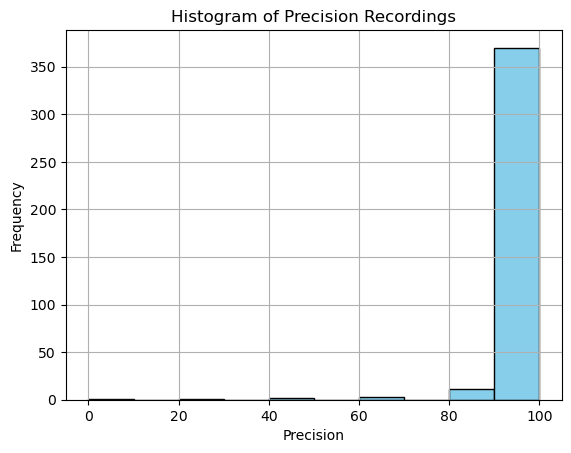

In [36]:
precisions_recordings = []
for player_id in df.player_id.unique():
    try:
        precision_at_k = precisionK(
            player_id=player_id, 
            df=df, 
            cosine_sim=cosine_sim, 
            player_performance_matrix=player_performance_matrix, 
            top_n=5
        )
        precisions_recordings.append(precision_at_k)
    except:
        pass


precision_df = pd.DataFrame(precisions_recordings, columns=["Precision"])

precision_df.Precision.hist(bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Precision")
plt.ylabel("Frequency")
plt.title("Histogram of Precision Recordings")

plt.show();





In [37]:
precision_df.describe()

,Precision
count,388.000000
mean,90.902062
std,8.743292
min,0.000000
25%,90.000000
50%,90.000000
75%,90.000000
max,100.000000


<i>The histogram of precision recordings shows that the recommender system performs exceptionally well for the majority of players. The dominant peak at 100% precision indicates that over 300 players received perfect recommendations, meaning all their top recommendations were relevant. A smaller number of players achieved precision scores between 40% and 90%, with very few cases below 40%. The presence of a few outliers at 0% suggests that the system occasionally fails to provide relevant recommendations for certain players, but these cases are rare.
This distribution aligns with the previously provided statistics:
- Mean Precision: 90.90%
- Median Precision: 90%
- Standard Deviation: 8.74

The histogram confirms the system's strong and consistent performance, with most recommendations being highly accurate. The few lower precision scores likely represent edge cases where the system struggles to find relevant matches, but overall, the recommender system is highly effective.</i>

#### Evaluation
<i>We can assess the quality of our recommendations using the Precision at K (P@K) metric. In essence, this metric helps us determine how many of the top K recommended players are relevant. For example, if I'm requesting a list of players similar to Player A, and Player A belongs to the 'elite' archetype, I would expect the recommended players to also be elite, or at least predominantly elite. The underlying assumption here is that when looking for similar players based on performance metrics, the archetype plays a key role. If the performance metrics driving the recommendations align with what defines an elite player, it is reasonable to expect that the most similar players will also be elite.</i>





In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Sample dataset (use the actual 'new_df' in your case)
# Aggregating data by player_id
aggregated_stats = new_df.groupby('player_id').agg({
    'points': 'mean',
    'rebounds': 'mean',
    'assists': 'mean',
    'steals': 'mean',
    'blocks': 'mean',
    'fg_pct': 'mean',
    'fg3_pct': 'mean',
    'ft_pct': 'mean',
    'archetype': 'first'  # Use 'first' or 'mode' depending on archetype consistency per player
}).reset_index()

# Step 1: Preprocess data and define features and target
X = aggregated_stats[['points', 'rebounds', 'assists', 'steals', 'blocks', 'fg_pct', 'fg3_pct', 'ft_pct']]  # Features
y = aggregated_stats['archetype']  # Target variable: archetype (categorical)

# Normalize features
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 2: Train Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict archetypes for all players
predicted_archetypes = rf_classifier.predict(X_normalized)

# Add predicted archetypes to the aggregated data
aggregated_stats['predicted_archetype'] = predicted_archetypes

# Step 3: Calculate Composite Score
weights = {
    'points': 0.25,
    'rebounds': 0.15,
    'assists': 0.15,
    'steals': 0.125,
    'blocks': 0.125,
    'fg_pct': 0.10,
    'fg3_pct': 0.05,
    'ft_pct': 0.05
}

# Normalize the aggregated stats (exclude player_id and archetype)
normalized_stats = pd.DataFrame(scaler.fit_transform(aggregated_stats.iloc[:, 1:9]), 
                                columns=aggregated_stats.columns[1:9], 
                                index=aggregated_stats['player_id'])

# Calculate the composite score
composite_scores = pd.Series(0, index=normalized_stats.index)
for metric, weight in weights.items():
    composite_scores += normalized_stats[metric] * weight

# Add the composite score to the aggregated stats
aggregated_stats['composite_score'] = composite_scores

# Step 4: Recommender System (Example)
# Get recommended players for a specific player (e.g., player_id = 1)
target_player_id = 1
target_player = aggregated_stats[aggregated_stats['player_id'] == target_player_id]

# Find players with the same predicted archetype and higher composite score
recommended_players = aggregated_stats[(aggregated_stats['predicted_archetype'] == target_player['predicted_archetype'].values[0]) & 
                                       (aggregated_stats['composite_score'] > target_player['composite_score'].values[0])]

# Sort by composite score to get top recommendations
recommended_players = recommended_players.sort_values(by='composite_score', ascending=False)

# Step 5: Display recommendations
print("Recommended Players based on Composite Score and Archetype:")
print(recommended_players[['player_id', 'predicted_archetype', 'composite_score']].head())


Recommended Players based on Composite Score and Archetype:
     player_id predicted_archetype  composite_score
330        332             regular         0.596111
277        279             regular         0.573451
365        367             regular         0.571084
359        361             regular         0.567034
270        272             regular         0.557208


In [67]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Drop rows with missing values in the relevant columns
new_df = df.dropna(subset=[
    'points', 'rebounds', 'assists', 'steals', 'blocks',
    'fg_pct', 'fg3_pct', 'ft_pct', 'player_name'
])

# Define the weights for each metric
weights = {
    'points': 0.25,
    'rebounds': 0.15,
    'assists': 0.15,
    'steals': 0.125,
    'blocks': 0.125,
    'fg_pct': 0.10,
    'fg3_pct': 0.05,
    'ft_pct': 0.05
}

# Aggregating the data based on player_id (mean values for each player)
aggregated_stats = new_df.groupby('player_id').agg({
    'points': 'mean',
    'rebounds': 'mean',
    'assists': 'mean',
    'steals': 'mean',
    'blocks': 'mean',
    'fg_pct': 'mean',
    'fg3_pct': 'mean',
    'ft_pct': 'mean'
}).reset_index()

# Create a mapping of player_id to player_name
player_name_map = new_df.drop_duplicates(subset='player_id')[['player_id', 'player_name']].set_index('player_id')['player_name']

# Map the player_name column to the aggregated_stats DataFrame
aggregated_stats['player_name'] = aggregated_stats['player_id'].map(player_name_map)

# Normalize only the numerical columns (excluding player_id and player_name)
scaler = MinMaxScaler()
numerical_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks', 'fg_pct', 'fg3_pct', 'ft_pct']
normalized_stats = pd.DataFrame(scaler.fit_transform(aggregated_stats[numerical_columns]), 
                                columns=numerical_columns, 
                                index=aggregated_stats['player_id'])

# Calculate the composite score using weighted sum of normalized stats
composite_scores = pd.Series(0, index=normalized_stats.index)
for metric, weight in weights.items():
    composite_scores += normalized_stats[metric] * weight

# Add the composite score as a new column in the aggregated DataFrame
aggregated_stats['composite_score'] = composite_scores

# Display the updated DataFrame with composite scores and player names
print(aggregated_stats)


     player_id     points  rebounds   assists    steals    blocks    fg_pct  \
0            0   8.900000  3.500000  2.100000  0.800000  0.600000  0.433000   
1            1  11.440000  4.100000  2.580000  0.940000  0.360000  0.440800   
2            2  12.633333  5.733333  3.566667  0.933333  0.900000  0.438000   
3            3   7.040000  4.080000  2.340000  0.820000  0.660000  0.444600   
4            4  11.633333  4.900000  2.233333  1.033333  0.600000  0.394333   
..         ...        ...       ...       ...       ...       ...       ...   
383        385  13.233333  4.500000  3.066667  1.166667  0.766667  0.443333   
384        386   8.500000  3.775000  1.675000  0.850000  0.425000  0.425000   
385        387  25.000000  6.200000  3.850000  0.150000  0.700000  0.526000   
386        388  10.000000  4.600000  2.120000  1.040000  0.780000  0.453000   
387        389   9.175000  4.375000  2.925000  0.850000  0.800000  0.434750   

      fg3_pct    ft_pct       player_name  composit

In [70]:
aggregated_stats = aggregated_stats.dropna(subset=[
            'points', 'rebounds', 'assists', 'steals', 'blocks',
            'fg_pct', 'fg3_pct', 'ft_pct','composite_score'
            
        ])

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Use 'composite_score' as the target variable for regression
X = aggregated_stats[['points', 'rebounds', 'assists', 'steals', 'blocks', 'fg_pct', 'fg3_pct', 'ft_pct']]
y = aggregated_stats['composite_score']  # Target variable: composite score (continuous)

# Step 1: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Step 3: Evaluate the regressor
y_pred = rf_regressor.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Step 4: Recommend players based on predicted composite score
def recommend_players_rf(player_id, rf_model, aggregated_stats, top_n=5):
    # Get the player's stats
    player_stats = new_df.loc[new_df['player_id'] == player_id, X.columns]
    if player_stats.empty:
        raise ValueError("Player ID not found in the dataset.")
    
    # Predict the player's composite score
    predicted_composite_score = rf_model.predict(player_stats)[0]
    
    # Sort players by predicted composite score
    aggregated_stats['predicted_composite_score'] = rf_model.predict(aggregated_stats[X.columns])
    recommended_players = aggregated_stats.sort_values(by='predicted_composite_score', ascending=False)
    
    # Exclude the player itself and return the top N similar players
    recommended_players = recommended_players[recommended_players['player_id'] != player_id]
    return recommended_players[['player_id', 'player_name', 'predicted_composite_score']].head(top_n)

# Test the recommendation system with composite score prediction
player_id = 116  # Example Player ID
recommended_players = recommend_players_rf(player_id, rf_regressor, aggregated_stats)
print("Recommended Players based on Composite Score:\n", recommended_players)


Mean Squared Error: 0.011419036565401873
Recommended Players based on Composite Score:
      player_id        player_name  predicted_composite_score
330        332       Paul Simmons                   0.531611
174        175  Ashley Mccullough                   0.508142
71          72     Joseph Johnson                   0.485983
39          40      Holly Hawkins                   0.485979
270        272         John Adams                   0.485906


In [73]:
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score
import numpy as np

# Calculate the predicted values
y_pred = rf_regressor.predict(X_test)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)

# Print the results
print(f"R-squared: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")


R-squared: -0.1057
Root Mean Squared Error (RMSE): 0.1069
Mean Absolute Error (MAE): 0.0856
Explained Variance Score: -0.0624


In [45]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define weights for each metric
weights = {
    'points': 0.25,
    'rebounds': 0.15,
    'assists': 0.15,
    'steals': 0.125,
    'blocks': 0.125,
    'fg_pct': 0.10,
    'fg3_pct': 0.05,
    'ft_pct': 0.05
}

# Assuming player_stats is your DataFrame with player performance metrics
player_stats = new_df[['player_id', 'points', 'rebounds', 'assists', 'steals', 'blocks', 'fg_pct', 'fg3_pct', 'ft_pct']]

# Normalize the player stats
scaler = MinMaxScaler()
normalized_stats = pd.DataFrame(scaler.fit_transform(player_stats.iloc[:, 1:]), 
                                columns=player_stats.columns[1:], 
                                index=player_stats['player_id'])

# Calculate the composite score
composite_scores = pd.Series(0, index=normalized_stats.index)
for metric, weight in weights.items():
    composite_scores += normalized_stats[metric] * weight

# Create a new column for the composite score in the player_stats DataFrame
player_stats['composite_score'] = composite_scores

# Display the updated DataFrame
print(player_stats)


ValueError: cannot reindex on an axis with duplicate labels

In [35]:
# Example ground truth for Player ID: 116
ground_truth = [158, 241, 288]  # IDs of players truly similar to player 116

# Get recommendations
player_id = 116
recommended = recommend_players(player_id, cosine_sim, player_performance_matrix, top_n=5)

# Calculate Precision, Recall, and F1
recommended_set = set(recommended)
ground_truth_set = set(ground_truth)

precision = len(recommended_set & ground_truth_set) / len(recommended_set)
recall = len(recommended_set & ground_truth_set) / len(ground_truth_set)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")


Precision: 0.60
Recall: 1.00
F1 Score: 0.75


In [32]:
explained_variance = svd.explained_variance_ratio_
print(f"Explained Variance Ratio by SVD Components: {explained_variance}")
print(f"Total Variance Retained: {explained_variance.sum():.2f}")


Explained Variance Ratio by SVD Components: [0.48312267 0.18264119 0.07798058]
Total Variance Retained: 0.74
